In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv', 'order_items')# Added payments.csv for specific handling
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sacanue@23',
    database='ecommerce'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/Sacchit Wathe/Desktop/Data Analytics/Ecommerce'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)
    
    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)
    
    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)
    
    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

# Close the connection
conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [18]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import mysql.connector
import numpy as np
db = mysql.connector.connect(
    host='localhost',
    user='root',
    password='Sacanue@23',
    database='ecommerce'
)

cur = db.cursor()



# List all unique cities where customers are located

In [3]:
query = """ select distinct customer_city from customers """
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0
0,franca
1,sao bernardo do campo
2,sao paulo
3,mogi das cruzes
4,campinas


# Count number of orders placed in 2017.

In [4]:
query = """ select count(order_id) from orders where year(order_purchase_timestamp) = 2017 """
cur.execute(query)
data = cur.fetchall()
"total orders placed in 2017 are", data[0][0]

('total orders placed in 2017 are', 45101)

# Find the total sales per category.

In [5]:
query = """ select upper(products.product_category) category, 
round(sum(payments.payment_value),2) sales
from products join order_items 
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by category
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data)
df.head()

,0,1
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33


# Calculate the percentage of orders that were paid in installments.


In [6]:
query = """ select (sum(case when payment_installments >= 1 then 1 else 0 end))/count(*)*100 from payments"""
cur.execute(query)
data = cur.fetchall()
" the percentage of orders that were paid in installments is ", data

(' the percentage of orders that were paid in installments is ',
 [(Decimal('99.9981'),)])

# Count the number of customers from each state. 

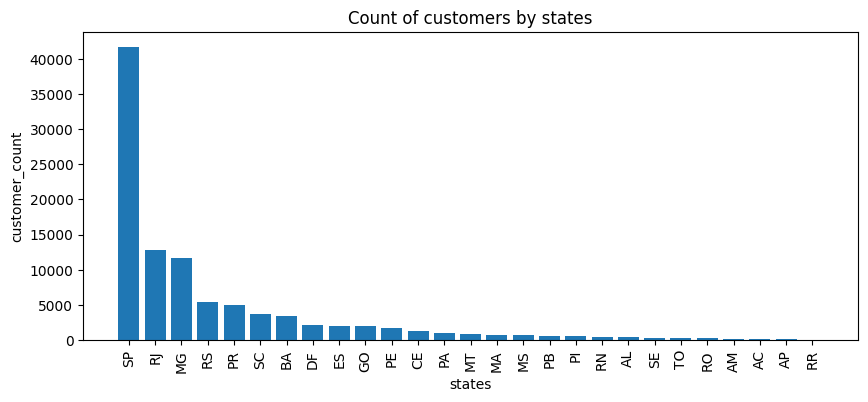

In [7]:
query = """ select customer_state,count(customer_id) from customers group by customer_state"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["state", "customer_cnt"])
df = df.sort_values(by = "customer_cnt", ascending = False)

plt.figure(figsize = (10, 4))
plt.bar(df["state"], df["customer_cnt"])
plt.xticks(rotation = 90)
plt.xlabel("states")
plt.ylabel("customer_count")
plt.title("Count of customers by states")
plt.show()

# Calculate the number of orders per month in 2018.

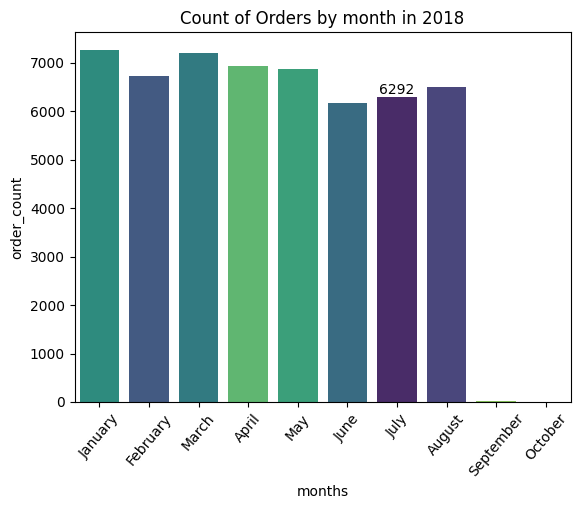

In [8]:
query = """ select monthname(order_purchase_timestamp) monthname, count(order_id) order_cnt 
from orders where year(order_purchase_timestamp) = 2018 
group by monthname
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["months", "order_count"])
month = ['January', 'February', 'March', 'April', 'May', 'June', 'July', 'August', 'September', 'October']

ax = sns.barplot(x = df["months"],y = df["order_count"],data = df, order = month, hue = df["months"], palette = "viridis")
plt.xticks(rotation = 50)
ax.bar_label(ax.containers[0])

plt.title("Count of Orders by month in 2018")

plt.show()

# Find the average number of products per order, grouped by customer city.

In [17]:
query = """ with count_per_order as 
(select orders.order_id, orders.customer_id, count(order_items.order_id) as oc
from orders join order_items
on orders.order_id = order_items.order_id
group by orders.order_id, orders.customer_id)


select customers.customer_city, round(avg(count_per_order.oc),2) average_order
from customers join count_per_order
on customers.customer_id = count_per_order.customer_id
group by customers.customer_city order by average_order desc

"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["City", "Average Products Per Orders"])
df.head(10)

,City,Average Products Per Orders
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.


In [32]:
query = """select upper(products.product_category) category, 
round((sum(payments.payment_value)/(select sum(payment_value) from payments))*100,2) sales
from products join order_items 
on products.product_id = order_items.product_id 
join payments
on payments.order_id = order_items.order_id
group by category order by sales desc
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category", "Percentage of Total Revenue"])
df.head(10)


,Product Category,Percentage of Total Revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.


In [44]:
query = """select upper(products.product_category),
count(order_items.product_id) ,
round(avg(order_items.price),2)
from products join order_items
on products.product_id = order_items.product_id
group by products.product_category;
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category", "Order Count", "Price"])
arr1 = df["Order Count"]
arr2 = df["Price"]

a = np.corrcoef([arr1, arr2])
print(" the correlation value between product price and the number of times a product has been purchased is ", a[0][1])

 the correlation value between product price and the number of times a product has been purchased is  -0.10631514167157562


# Calculate the total revenue generated by each seller, and rank them by revenue.


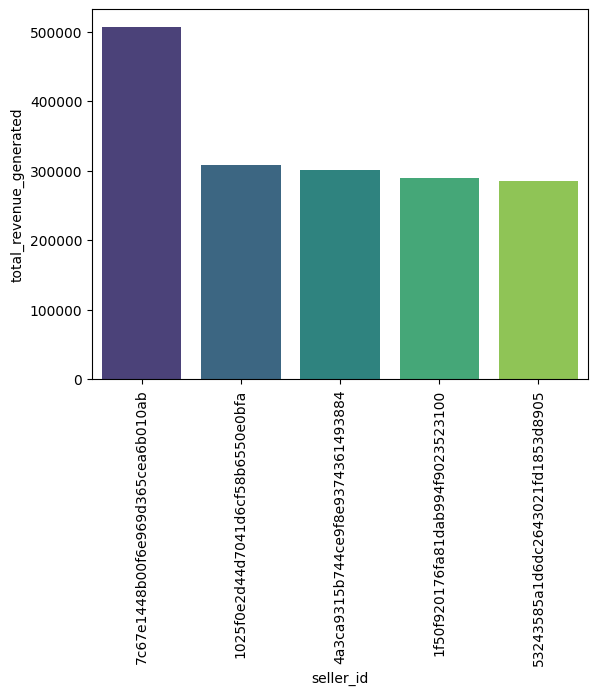

In [13]:
query = """ select *, dense_rank() over(order by revenue desc) as rn from
(select order_items.seller_id, sum(payments.payment_value) revenue
from order_items join payments
on order_items.order_id = payments.order_id
group by order_items.seller_id) as a
"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["seller_id", "total_revenue_generated", "rank"])
df = df.head()
sns.barplot(x = "seller_id", y = "total_revenue_generated", data = df, hue = df["seller_id"], palette = "viridis")
plt.xticks(rotation = 90)
plt.show()

# Calculate the moving average of order values for each customer over their order history.

In [24]:
query = """select customer_id, order_purchase_timestamp, payment,
avg(payment) over(partition by customer_id order by order_purchase_timestamp
rows between 2 preceding and current row) as mov_avg
from
(select orders.customer_id, orders.order_purchase_timestamp,payments.payment_value as payment
from payments join orders
on payments.order_id = orders.order_id) as x"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["customer_id", "order_purchase_timestamp", "payment", "moving_average"])
df.head(10)

,customer_id,order_purchase_timestamp,payment,moving_average
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.739998
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.410004
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.419998
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.350006
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.010002
5,0004164d20a9e969af783496f3408652,2017-04-12 08:35:12,71.80,71.800003
6,000419c5494106c306a97b5635748086,2018-03-02 17:47:40,49.40,49.400002
7,00046a560d407e99b969756e0b10f282,2017-12-18 11:08:30,166.59,166.589996
8,00050bf6e01e69d5c0fd612f1bcfb69c,2017-09-17 16:04:44,85.23,85.230003
9,000598caf2ef4117407665ac33275130,2018-08-11 12:14:35,1255.71,1255.709961


# Calculate the cumulative sales per month for each year.


In [27]:
query = """select years, months, payment, round(sum(payment) 
over(order by years, months),2) cumulative_sales from 
(select year(orders.order_purchase_timestamp) as years, 
month(orders.order_purchase_timestamp) as months,
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years, months order by years, months) as a"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "months", "payment", "cumulative_sales"])
df.head()

,years,months,payment,cumulative_sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39


# Calculate the year-over-year growth rate of total sales.


In [42]:
query = """ with x as(select year(orders.order_purchase_timestamp) as years, 
round(sum(payments.payment_value),2) as payment from orders join payments
on orders.order_id = payments.order_id
group by years order by years)

select years, round(((payment - lag(payment, 1) over (order by years)) / lag(payment, 1) over (order by years))*100,2)  from x"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Years", "yoy_%_growth"])
df.head()

,Years,yoy_%_growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Calculate the retention rate of customers, defined as the percentage of customers who make another purchase within 6 months of their first purchase.


In [45]:
query = """ with a as (select customers.customer_id, min(orders.order_purchase_timestamp) first_order
from customers join orders
on customers.customer_id = orders.order_id
group by customers.customer_id),

b as (select a.customer_id, count(distinct orders.order_purchase_timestamp) next_order
from a join orders
on orders.customer_id = a.customer_id and orders.order_purchase_timestamp > first_order
and orders.order_purchase_timestamp < date_add(first_order, interval 6 month)
group by a.customer_id)

select 100*(count(distinct a.customer_id) / count(distinct b.customer_id))
from a left join b
on a.customer_id = b.customer_id"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Retention rate"])
df.head()

,Retention rate
0,None


# Identify the top 3 customers who spent the most money in each year.

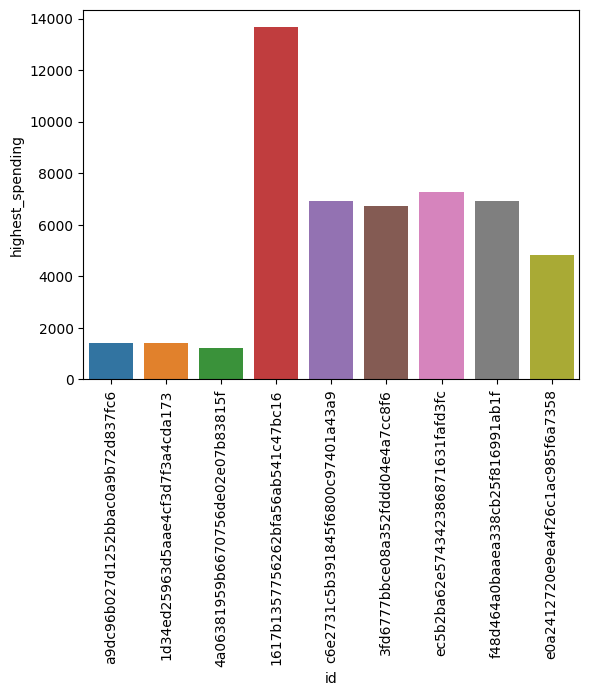

In [52]:
query = """select years, customer_id, payment, d_rank from 
(select year(orders.order_purchase_timestamp) years, orders.customer_id, sum(payments.payment_value) payment,
dense_rank() over(partition by year(orders.order_purchase_timestamp) order by sum(payments.payment_value) desc) d_rank
from orders join payments
on payments.order_id = orders.order_id
group by year(orders.order_purchase_timestamp), orders.customer_id) as x
where d_rank<=3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["years", "id", "highest_spending", "rank"])
sns.barplot(x = "id", y = "highest_spending", data = df, hue = "id")
plt.xticks(rotation = 90)
plt.show()